In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, tqdm_pandas
import multiprocessing as mp

#For Preprocessing
import re
import string
import nltk
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses
import tensorflow.keras.backend as K

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
%matplotlib inline
pd.options.plotting.backend = "plotly"
warnings.filterwarnings('ignore')
tqdm_pandas(tqdm()) # tqdm.pandas()

RS = 42

[nltk_data] Downloading package stopwords to /home/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
0it [00:00, ?it/s]


# Data Read & Preprocessing

In [2]:
def parallelize_dataframe(df, func):
    num_processes = mp.cpu_count()
    df_split = np.array_split(df, num_processes)
    with mp.Pool(num_processes) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def main_preprocessing(tweet):
    def remove_urls(tweet):
        return re.sub(r"http(s?)://[\S]+", '', tweet)

    def remove_at_links(tweet):
        return re.sub(r"\B(@)\S+", '', tweet)
    
    def remove_non_ascii_chars(tweet):
        ascii_chars = set(string.printable)
        for c in tweet:
            if c not in ascii_chars:
                tweet = tweet.replace(c,'')
        return tweet

    def remove_emojis(tweet):
            emoj = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"
                u"\u3030"
                u"\u23f0"
                u"\u23f1"
                u"\u23f2"
                u"\u23f3"
                              "]+", re.UNICODE)
            return re.sub(emoj, '', tweet)

    def fix_ax_nots(tweet):
        tweet = tweet.replace(" dont ", " do not ")
        tweet = tweet.replace(" don't ", " do not ")
        tweet = tweet.replace(" doesnt ", " does not ")
        tweet = tweet.replace(" doesn't ", " does not ")
        tweet = tweet.replace(" wont ", " will not ")
        tweet = tweet.replace(" won't ", " will not ")
        tweet = tweet.replace(" cant ", " cannot ")
        tweet = tweet.replace(" can't ", " cannot ")
        tweet = tweet.replace(" couldnt ", " could not ")
        tweet = tweet.replace(" couldn't ", " could not ")
        tweet = tweet.replace(" shouldnt ", " should not ")
        tweet = tweet.replace(" shouldn't ", " should not ")
        tweet = tweet.replace(" wouldnt ", " would not ")
        tweet = tweet.replace(" wouldn't ", " would not ")
        tweet = tweet.replace(" mustnt ", " must not ")
        tweet = tweet.replace(" mustn't ", " must not ")
        return tweet

    def fix_personal_pronouns_and_verb(tweet):
        tweet = tweet.replace(" im ", " i am ")
        tweet = tweet.replace(" youre ", " you are")
        tweet = tweet.replace(" hes ", " he is") # ? he's can be he has as well
        tweet = tweet.replace(" shes ", " she is")
        tweet = tweet.replace(" theyre ", " they are")
        tweet = tweet.replace(" ive ", " i have ")
        tweet = tweet.replace(" youve ", " you have ")
        tweet = tweet.replace(" weve ", " we have ")
        tweet = tweet.replace(" theyve ", " they have ")
        tweet = tweet.replace(" youll ", " you will ")
        tweet = tweet.replace(" theyll ", " they will ")
        return tweet

    def fix_special_chars(tweet):
        tweet = tweet.replace("&amp;", " and ").replace("#", " ")
        tweet = re.sub(r'\(\d+/\d+\)|(\d/)', '', tweet)
        return tweet
    
    try:
        tweet = tweet.lower()
        tweet = remove_emojis(tweet)
        tweet = remove_urls(tweet)
        tweet = remove_at_links(tweet)
        tweet = remove_non_ascii_chars(tweet)
        tweet = fix_special_chars(tweet)
        tweet = fix_ax_nots(tweet)
        tweet = fix_personal_pronouns_and_verb(tweet)
    except:
        tweet = np.nan
    return tweet

def async_main_preprocessing(data):
    data = data[['text']]
    data['cleantext'] = data.progress_apply(lambda x: main_preprocessing(x['text']), axis = 1)
    data = data.dropna()
    return data

def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    try:
        tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet)
        words = tweet.split()
        words = [w for w in words if w not in stopwords.words("english")]
        words = [PorterStemmer().stem(w) for w in words]
    except:
        words=['None']
    return words

def async_tweet_to_words(data):
    data['words'] = data.progress_apply(lambda x: tweet_to_words(x['cleantext']), axis = 1)
    return data

In [3]:
df = pd.read_csv('Bitcoin_tweets.csv')
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

Data Size: 1232809x13


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


## Sampling

In [4]:
df = df.sample(int(5e+5), random_state = RS)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

Data Size: 500000x13


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
1110617,Chase,"Washington, DC",#AJ1Fan #VGXheroes,2009-04-29 01:50:56,97.0,132,342,False,2021-08-26 03:04:40,Listening to #VGXheroes discussing the future ...,"['VGXheroes', 'vgx', 'crypto', 'bitcoin', 'VGX...",Twitter for iPhone,False
505565,Sofika Anisa,INDONESIA,is in a difficult phase,2018-11-25 21:01:55,247.0,2759.0,1112.0,False,2021-07-20 06:14:04,@HswapDEX amazing to project\n@AsepSM0508\n\n@...,"['Hswap', 'DeFi', 'HECO', 'Airdrop', 'Bitcoin']",Twitter Web App,False
280163,BTC Pulse,NaN,Updates about BTC USD change value 📈,2017-11-08 21:16:39,935.0,1.0,11.0,False,2021-07-05 00:00:30,BTC hourly update\n$35297.81 | -0.24%📉\n...,"['BTCUSD', 'Bitcoin']",btcpulse,False
843127,JohnKammy,NaN,"An active #crypto enthusiast, Blogger, Explore...",2020-10-26 07:22:03,97.0,257.0,270.0,False,2021-08-05 13:29:24,#Bitcoin Price Is All Set To Break The Pattern...,"['Bitcoin', 'BTC', 'Cryptonews']",Twitter Web App,False
757256,Barry Hope,"Manchester, England",Queen pack rangers fan 💙🤍🇬🇧🇮🇪,2013-03-19 02:37:31,4.0,7.0,3.0,False,2021-08-08 23:59:34,@Super_Crypto Next support level for #bitcoin ...,['bitcoin'],Twitter for Android,False


In [5]:
df = parallelize_dataframe(df, async_main_preprocessing)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

17858it [00:09, 1852.43it/s]
17858it [00:09, 1830.67it/s]
17858it [00:09, 1811.37it/s]
17858it [00:09, 1787.53it/s]
17857it [00:10, 1775.78it/s]
17857it [00:10, 1764.91it/s]
17857it [00:10, 1740.11it/s]
17857it [00:10, 1738.68it/s]
17857it [00:10, 1725.01it/s]
17857it [00:10, 1708.38it/s]
17857it [00:10, 1696.39it/s]
17857it [00:10, 1681.77it/s]
17857it [00:10, 1671.95it/s]
17857it [00:10, 1658.59it/s]
17857it [00:10, 1644.69it/s]
17857it [00:10, 1627.90it/s]
17857it [00:11, 1618.82it/s]
17857it [00:11, 1606.22it/s]
17857it [00:11, 1591.68it/s]
17857it [00:11, 1580.51it/s]
17857it [00:11, 1569.93it/s]
17857it [00:11, 1559.10it/s]
17857it [00:11, 1548.18it/s]
17857it [00:11, 1538.29it/s]
17857it [00:11, 1528.29it/s]
17857it [00:11, 1518.30it/s]
17857it [00:11, 1506.94it/s]
17857it [00:11, 1499.32it/s]


Data Size: 499999x2


,text,cleantext
1110617,Listening to #VGXheroes discussing the future ...,listening to vgxheroes discussing the future ...
505565,@HswapDEX amazing to project\n@AsepSM0508\n\n@...,amazing to project\n\n\n\n\n\n\n hswap defi ...
280163,BTC hourly update\n$35297.81 | -0.24%📉\n...,btc hourly update\n$35297.81 | -0.24%\n$...
843127,#Bitcoin Price Is All Set To Break The Pattern...,bitcoin price is all set to break the pattern...
757256,@Super_Crypto Next support level for #bitcoin ...,"next support level for bitcoinis at $37,000 ..."


In [6]:
df = parallelize_dataframe(df, async_tweet_to_words)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

17857it [01:17, 230.62it/s]
17858it [01:17, 230.31it/s]
17858it [01:17, 230.02it/s]
17857it [01:17, 229.57it/s]
17857it [01:17, 229.34it/s]
17858it [01:17, 229.34it/s]
17857it [01:17, 229.09it/s]
17857it [01:17, 228.99it/s]
17857it [01:17, 228.95it/s]
17857it [01:18, 228.91it/s]
17857it [01:18, 228.89it/s]
17857it [01:18, 228.77it/s]
17741it [01:18, 455.23it/s]
17857it [01:18, 227.42it/s]
17852it [01:18, 412.55it/s]
17746it [01:18, 453.81it/s]
17800it [01:18, 317.31it/s]
17857it [01:18, 228.54it/s]
17857it [01:18, 228.36it/s]
17857it [01:18, 228.12it/s]
17857it [01:18, 227.88it/s]
17857it [01:18, 227.86it/s]
17857it [01:18, 227.83it/s]
17857it [01:18, 227.78it/s]
17857it [01:18, 227.67it/s]
17857it [01:18, 227.19it/s]
17857it [01:18, 226.98it/s]
17857it [01:18, 226.73it/s]


Data Size: 499999x3


,text,cleantext,words
1110617,Listening to #VGXheroes discussing the future ...,listening to vgxheroes discussing the future ...,"[listen, vgxhero, discuss, futur, vgx, token, ..."
505565,@HswapDEX amazing to project\n@AsepSM0508\n\n@...,amazing to project\n\n\n\n\n\n\n hswap defi ...,"[amaz, project, hswap, defi, heco, airdrop, bi..."
280163,BTC hourly update\n$35297.81 | -0.24%📉\n...,btc hourly update\n$35297.81 | -0.24%\n$...,"[btc, hourli, updat, 35297, 81, 0, 24, btc, bt..."
843127,#Bitcoin Price Is All Set To Break The Pattern...,bitcoin price is all set to break the pattern...,"[bitcoin, price, set, break, pattern, pump, du..."
757256,@Super_Crypto Next support level for #bitcoin ...,"next support level for bitcoinis at $37,000 ...","[next, support, level, bitcoini, 37, 000, hope..."


In [7]:
def unlist(list):
        words=''
        for item in list:
            words+=item+' '
        return words

def async_vader(data):
    label = 'words'
    sid = SentimentIntensityAnalyzer()
    data["vader_neg"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    data["vader_neu"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    data["vader_pos"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    data["vader_comp"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    data['cleantext2'] = data[label].apply(lambda x: unlist(x))
    return data

In [8]:
df = parallelize_dataframe(df, async_vader) 
df.head()

,text,cleantext,words,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
1110617,Listening to #VGXheroes discussing the future ...,listening to vgxheroes discussing the future ...,"[listen, vgxhero, discuss, futur, vgx, token, ...",0.000,1.000,0.000,0.0000,listen vgxhero discuss futur vgx token crypto ...
505565,@HswapDEX amazing to project\n@AsepSM0508\n\n@...,amazing to project\n\n\n\n\n\n\n hswap defi ...,"[amaz, project, hswap, defi, heco, airdrop, bi...",0.000,1.000,0.000,0.0000,amaz project hswap defi heco airdrop bitcoin
280163,BTC hourly update\n$35297.81 | -0.24%📉\n...,btc hourly update\n$35297.81 | -0.24%\n$...,"[btc, hourli, updat, 35297, 81, 0, 24, btc, bt...",0.000,1.000,0.000,0.0000,btc hourli updat 35297 81 0 24 btc btcusd bitc...
843127,#Bitcoin Price Is All Set To Break The Pattern...,bitcoin price is all set to break the pattern...,"[bitcoin, price, set, break, pattern, pump, du...",0.245,0.755,0.000,-0.3818,bitcoin price set break pattern pump dump btc ...
757256,@Super_Crypto Next support level for #bitcoin ...,"next support level for bitcoinis at $37,000 ...","[next, support, level, bitcoini, 37, 000, hope...",0.036,0.616,0.347,0.9022,next support level bitcoini 37 000 hope see le...


In [9]:
def class_giver(neg_score, pos_score):
    if neg_score > 0:
        return 0
    elif pos_score > 0:
        return 2
    else:
        return 1
    
def async_class_giver(data):
    data['class']= data.apply(lambda x: class_giver(x['vader_neg'], x['vader_pos']), axis = 1)
    return data

In [10]:
df = parallelize_dataframe(df, async_class_giver)
df = df.reset_index(drop = True)
df.head()

,text,cleantext,words,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,Listening to #VGXheroes discussing the future ...,listening to vgxheroes discussing the future ...,"[listen, vgxhero, discuss, futur, vgx, token, ...",0.000,1.000,0.000,0.0000,listen vgxhero discuss futur vgx token crypto ...,1
1,@HswapDEX amazing to project\n@AsepSM0508\n\n@...,amazing to project\n\n\n\n\n\n\n hswap defi ...,"[amaz, project, hswap, defi, heco, airdrop, bi...",0.000,1.000,0.000,0.0000,amaz project hswap defi heco airdrop bitcoin,1
2,BTC hourly update\n$35297.81 | -0.24%📉\n...,btc hourly update\n$35297.81 | -0.24%\n$...,"[btc, hourli, updat, 35297, 81, 0, 24, btc, bt...",0.000,1.000,0.000,0.0000,btc hourli updat 35297 81 0 24 btc btcusd bitc...,1
3,#Bitcoin Price Is All Set To Break The Pattern...,bitcoin price is all set to break the pattern...,"[bitcoin, price, set, break, pattern, pump, du...",0.245,0.755,0.000,-0.3818,bitcoin price set break pattern pump dump btc ...,0
4,@Super_Crypto Next support level for #bitcoin ...,"next support level for bitcoinis at $37,000 ...","[next, support, level, bitcoini, 37, 000, hope...",0.036,0.616,0.347,0.9022,next support level bitcoini 37 000 hope see le...,0


In [11]:
df['class'].value_counts()

2    209169
1    183501
0    107329
Name: class, dtype: int64

# Model

## Tokenization

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('\nAfter Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 listen vgxhero discuss futur vgx token crypto bitcoin vgxhero 

After Tokenization & Padding 
 [ 937  952   30 2633   70    3    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Train-Test Split

In [13]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RS)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (299999, 50) (299999, 3)
Validation Set:  (100000, 50) (100000, 3)
Test Set:  (100000, 50) (100000, 3)


## Training

In [14]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [15]:
# Optimizer
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# Model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])


In [16]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
4688/4688 [==============================] - 52s 11ms/step - loss: 0.5363 - accuracy: 0.7701 - precision: 0.8111 - recall: 0.7199 - val_loss: 0.3706 - val_accuracy: 0.8460 - val_precision: 0.8538 - val_recall: 0.8324
Epoch 2/10
4688/4688 [==============================] - 50s 11ms/step - loss: 0.3407 - accuracy: 0.8704 - precision: 0.8755 - recall: 0.8618 - val_loss: 0.2654 - val_accuracy: 0.9091 - val_precision: 0.9126 - val_recall: 0.9027
Epoch 3/10
4688/4688 [==============================] - 50s 11ms/step - loss: 0.2513 - accuracy: 0.9172 - precision: 0.9200 - recall: 0.9132 - val_loss: 0.2016 - val_accuracy: 0.9376 - val_precision: 0.9395 - val_recall: 0.9348
Epoch 4/10
4688/4688 [==============================] - 50s 11ms/step - loss: 0.2033 - accuracy: 0.9402 - precision: 0.9420 - recall: 0.9379 - val_loss: 0.1736 - val_accuracy: 0.9471 - val_precision: 0.9491 - val_recall: 0.9447
Epoch 5/10
4688/4688 [==============================] - 50s 11ms/step - loss: 0.1763 - a

## Metrics

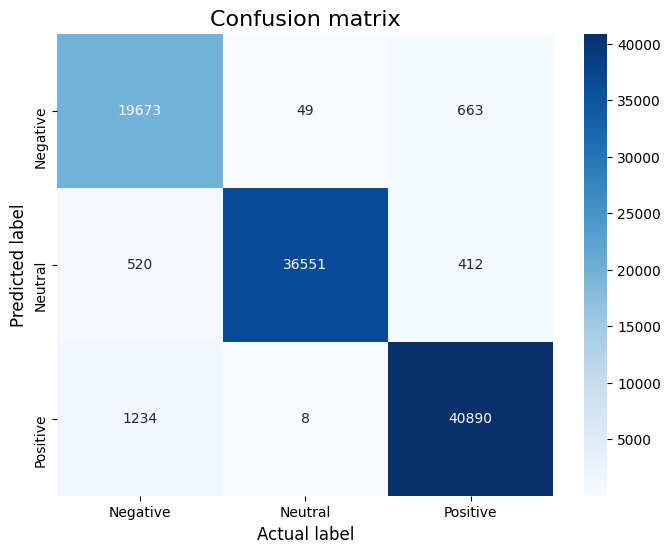

In [17]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
    
plot_confusion_matrix(model, X_test, y_test)

In [18]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Accuracy  : 0.9711
Precision : 0.9714
Recall    : 0.9707
F1 Score  : 0.9711


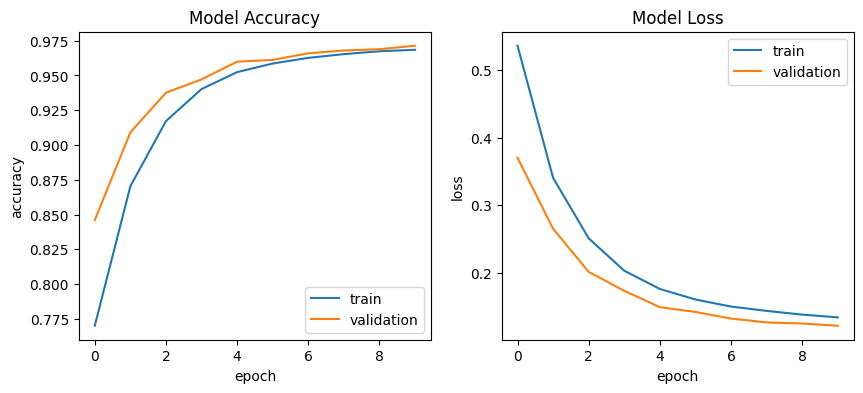

In [19]:
plot_training_hist(history)

# Our data prediction

In [20]:
def files_search(directory : 'str', extention : 'str') -> list:
    all_files = os.listdir(directory)    
    requested_files = list(filter(lambda f: f.endswith(extention), all_files))
    return requested_files



files = files_search(directory = 'data', extention='xlsx')
frames = [pd.read_excel(f'data/{file}') for file in files]

for i in range(len(files)):
    frames[i]['Ticker'] = files[i].replace('.xlsx', '')
    
data = pd.concat(frames)
data = data.drop_duplicates(subset = ['Text']).reset_index(drop = True)
print(f'Data Size: {data.shape[0]}x{data.shape[1]}')
data.head()

Data Size: 49820x7


,Text,Date,Likes,Comments,Retweets,Views,Ticker
0,RT @ZcashCommGrants: Anyone working in the #Zc...,17-01-2023 19:01:45,0,0,15,0,ZECUSDT
1,The @ZFAVClub will be spun up and organized by...,12-01-2023 18:30:32,14,1,2,594,ZECUSDT
2,The @ZFAVClub will host meetups &amp; online ...,12-01-2023 18:29:20,11,1,1,576,ZECUSDT
3,The @ZcashFoundation is excited to announce a ...,12-01-2023 18:24:18,53,7,20,4192,ZECUSDT
4,Zcon Voices events will complement ZF’s annual...,10-01-2023 22:15:55,12,1,2,802,ZECUSDT


In [21]:
df2 = data.copy()
df2 = df2.rename(columns = {'Text': 'text'})
df2 = parallelize_dataframe(df2, async_main_preprocessing)
df2 = parallelize_dataframe(df2, async_tweet_to_words)
df2['cleantext2'] = df2['words'].apply(lambda x: unlist(x))

# Tokenisation
X = tokenizer.texts_to_sequences(df2['cleantext2'])
X = pad_sequences(X, padding='post', maxlen=max_len)

# Predictions
predictions = model.predict(X)
result = pd.DataFrame(predictions, columns = ['Negative', 'Neutral', 'Positive'])

data = pd.concat([data, result], axis = 1)
data['Class'] = np.argmax(predictions, axis=1)

names = pd.DataFrame(data = {'Class': [0, 1, 2], 'Sentiment' : ['Negative', 'Neutral', 'Positive']})
data = data.merge(names, how = 'left', on = ['Class'])
data = data.drop(columns = ['Class'])
for col in ['Negative', 'Neutral', 'Positive']:
    data[col] = np.round(data[col], 5)
data

1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1780it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [10:55,  2.72it/s]
1779it [11:01,  2.69it/s] 
1780it [11:02,  2.69it/s] 
1780it [11:02,  2.69it/s] 
1779it [11:02,  2.68it/s] 
1779it [11:03,  2.68it/s] 
1779it [11:03,  2.68it/s] 
1780it [11:03,  2.68it/s] 
1780it [11:03,  2.68it/s] 
1780it [11:03,  2.68it/s] 
1780it [11:03,  2.68it/s] 
17

,Text,Date,Likes,Comments,Retweets,Views,Ticker,Negative,Neutral,Positive,Sentiment
0,RT @ZcashCommGrants: Anyone working in the #Zc...,17-01-2023 19:01:45,0,0,15,0,ZECUSDT,0.14324,0.80916,0.04760,Neutral
1,The @ZFAVClub will be spun up and organized by...,12-01-2023 18:30:32,14,1,2,594,ZECUSDT,0.08430,0.00001,0.91569,Positive
2,The @ZFAVClub will host meetups &amp; online ...,12-01-2023 18:29:20,11,1,1,576,ZECUSDT,0.02883,0.95615,0.01502,Neutral
3,The @ZcashFoundation is excited to announce a ...,12-01-2023 18:24:18,53,7,20,4192,ZECUSDT,0.06131,0.00000,0.93869,Positive
4,Zcon Voices events will complement ZF’s annual...,10-01-2023 22:15:55,12,1,2,802,ZECUSDT,0.23400,0.00004,0.76596,Positive
...,...,...,...,...,...,...,...,...,...,...,...
49815,Do you know we have a $FLUX merch store? Check...,29-06-2022 05:28:12,60,5,22,0,FLUXUSDT,0.01285,0.00000,0.98715,Positive
49816,RT @LizaFlux: I just can't stop singing it!! 😅...,28-06-2022 21:21:25,0,0,31,0,FLUXUSDT,0.98570,0.00438,0.00993,Negative
49817,Come join us with @Cephii1 to chat about the u...,28-06-2022 20:53:03,58,0,12,0,FLUXUSDT,0.11326,0.00000,0.88674,Positive
49818,Join our man @shotsbymatta and he chats with @...,28-06-2022 17:25:17,68,1,26,0,FLUXUSDT,0.05728,0.00023,0.94249,Positive


In [22]:
data.to_excel('sentiment_score.xlsx', index = False)

# finBERT

https://huggingface.co/yiyanghkust/finbert-tone

In [26]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline, Trainer, TrainingArguments

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}
    
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

loading configuration file https://huggingface.co/yiyanghkust/finbert-tone/resolve/main/config.json from cache at /home/vlad/.cache/huggingface/transformers/70d1215b8fdafe3265e07d33b038971980e2f845842193d327e57e391fc58393.e033c3bdc62e71f1b657c29753d6b96d9d23207bef18e9ab1e2b6310e55d94e4
Model config BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Neutral",
    "1": "Positive",
    "2": "Negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Negative": 2,
    "Neutral": 0,
    "Positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
 

In [27]:
tokenized_texts = tokenizer(df2['cleantext'].to_list(),
                            truncation=True,
                            padding='max_length',
                            max_length=128
                           )

test_dataset = SimpleDataset(tokenized_texts)
trainer = Trainer(model=finbert)
predictions = trainer.predict(test_dataset).predictions

result = pd.DataFrame(predictions, columns = ['Neutral (finBERT)', 'Positive (finBERT)', 'Negative (finBERT)'])
names = pd.DataFrame(data = {'Class': [0, 1, 2], 'Sentiment (finBERT)' : ['Neutral', 'Positive', 'Negative']})

result['Class'] = np.argmax(predictions, axis=1)
result = result.merge(names, how = 'left', on = ['Class'])
result = result.drop(columns = ['Class'])
result.head()

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 49820
  Batch size = 8


,Neutral (finBERT),Positive (finBERT),Negative (finBERT),Sentiment (finBERT)
0,8.080149,-7.487980,-3.819676,Neutral
1,5.588332,-3.445281,-7.033362,Neutral
2,9.111086,-5.803102,-5.596067,Neutral
3,-2.476936,7.696498,-9.104772,Positive
4,1.373140,3.921369,-8.702026,Positive


# CryptoBert
https://huggingface.co/ElKulako/cryptobert

In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

cryptobert = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")

In [25]:
tokenized_texts = tokenizer(df2['cleantext'].to_list(),
                            truncation=True,
                            padding='max_length',
                            max_length=64
                           )

test_dataset = SimpleDataset(tokenized_texts)
trainer = Trainer(model=cryptobert)
predictions = trainer.predict(test_dataset).predictions

result2 = pd.DataFrame(predictions, columns = ['Bearish (cryptoBERT)', 'Neutral (cryptoBERT)', 'Bullish (cryptoBERT)'])
names = pd.DataFrame(data = {'Class': [0, 1, 2], 'Sentiment (cryptoBERT)' : ['Bearish', 'Neutral', 'Bullish']})

result2['Class'] = np.argmax(predictions, axis=1)
result2 = result2.merge(names, how = 'left', on = ['Class'])
result2 = result2.drop(columns = ['Class']).head()
result2.head()

***** Running Prediction *****
  Num examples = 49820
  Batch size = 8


,Bearish (cryptoBERT),Neutral (cryptoBERT),Bullish (cryptoBERT),Sentiment (cryptoBERT)
0,-5.682328,3.306134,1.692341,Neutral
1,-5.578339,3.451711,1.182487,Neutral
2,-6.393364,3.747444,1.632040,Neutral
3,-6.199106,3.115969,2.299274,Neutral
4,-5.010477,1.935445,2.816571,Bullish


In [28]:
full_result = pd.concat([data, result, result2], axis = 1)
full_result.head()

,Text,Date,Likes,Comments,Retweets,Views,Ticker,Negative,Neutral,Positive,Sentiment,Neutral (finBERT),Positive (finBERT),Negative (finBERT),Sentiment (finBERT),Bearish (cryptoBERT),Neutral (cryptoBERT),Bullish (cryptoBERT),Sentiment (cryptoBERT)
0,RT @ZcashCommGrants: Anyone working in the #Zc...,17-01-2023 19:01:45,0,0,15,0,ZECUSDT,0.14324,0.80916,0.04760,Neutral,8.080149,-7.487980,-3.819676,Neutral,-5.682328,3.306134,1.692341,Neutral
1,The @ZFAVClub will be spun up and organized by...,12-01-2023 18:30:32,14,1,2,594,ZECUSDT,0.08430,0.00001,0.91569,Positive,5.588332,-3.445281,-7.033362,Neutral,-5.578339,3.451711,1.182487,Neutral
2,The @ZFAVClub will host meetups &amp; online ...,12-01-2023 18:29:20,11,1,1,576,ZECUSDT,0.02883,0.95615,0.01502,Neutral,9.111086,-5.803102,-5.596067,Neutral,-6.393364,3.747444,1.632040,Neutral
3,The @ZcashFoundation is excited to announce a ...,12-01-2023 18:24:18,53,7,20,4192,ZECUSDT,0.06131,0.00000,0.93869,Positive,-2.476936,7.696498,-9.104772,Positive,-6.199106,3.115969,2.299274,Neutral
4,Zcon Voices events will complement ZF’s annual...,10-01-2023 22:15:55,12,1,2,802,ZECUSDT,0.23400,0.00004,0.76596,Positive,1.373140,3.921369,-8.702026,Positive,-5.010477,1.935445,2.816571,Bullish


In [29]:
full_result.to_excel('sentiment_3_models.xlsx', index = False)